# Problem 12.9

**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 12**

**Problem 12.9**


**When the spectral response of the reference cell is different from the cell under test and/or the spectrum of the simulator lamp is different from the reference spectrum, the spectral mismatch factor $M_f$ can be used to correct the measurement. In this problem, the QE of a GaInP  cell (device under test) and a calibrated Si solar cell (reference cell) are provided. Calculate their respective SR and estimate the corresponding spectral mismatch factor, when the test cell is measured using a quartz tungsten halogen lamp, relative to the reference spectrum AM1.5 G.**

We will use the package [pandas](https://pandas.pydata.org/) to handle the data and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We start by importing the data for the solar spectra.

In [11]:
reference = pd.read_csv('data/Reference_spectrum_ASTM-G173-03.csv', index_col=0, header=0) 
reference

AM0                   AM1.5G  \
Wvlgth nm  Etr W*m-2*nm-1  Global tilt  W*m-2*nm-1   
280              8.20E-02                 4.73E-23   
280.5            9.90E-02                 1.23E-21   
281              1.50E-01                 5.69E-21   
281.5            2.12E-01                 1.57E-19   
...                   ...                      ...   
3980             8.84E-03                 7.39E-03   
3985             8.80E-03                 7.43E-03   
3990             8.78E-03                 7.37E-03   
3995             8.70E-03                 7.21E-03   
4000             8.68E-03                 7.10E-03   

                                  AM1.5D  
Wvlgth nm  Direct+circumsolar W*m-2*nm-1  
280                             2.54E-26  
280.5                           1.09E-24  
281                             6.13E-24  
281.5                           2.75E-22  
...                                  ...  
3980                            7.40E-03  
3985                            7.45E-03  
3990                            7.39E-03  
3995                            7.23E-03  
4000                            7.12E-03  

[2003 rows x 3 columns]

In [12]:
reference.drop(reference.index[0], inplace=True)   # remove row including information on units
reference=reference.astype(float)                  # convert values to float for easy operation
reference.index=reference.index.astype(float)      # convert indexes to float for easy operation

We import the data for the quartz tungsten halogen lamp.

In [13]:
quartz_w = pd.read_csv('data/W lamp spectral irradiance.csv', index_col=0, header=0) 
quartz_w

W halogen lamp (W*m-2*nm-1)
wavelength (nm)                             
300                                 0.000001
301                                 0.000010
302                                 0.000100
303                                 0.000200
304                                 0.000300
...                                      ...
1196                                0.654304
1197                                0.653941
1198                                0.651544
1199                                0.647531
1200                                0.644677

[901 rows x 1 columns]

We can also plot the AM1.5G spectra and the quartz tungsten halogen lamp spectra.

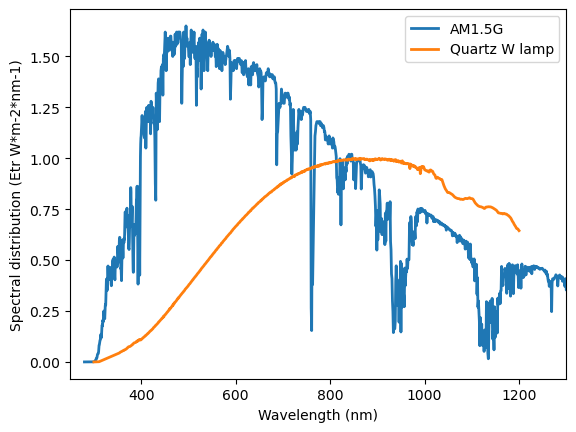

In [14]:
plt.plot(reference['AM1.5G'], 
         linewidth=2, label='AM1.5G')
plt.plot(quartz_w['W halogen lamp (W*m-2*nm-1)'], 
         linewidth=2, label='Quartz W lamp')
plt.ylabel('Spectral distribution (Etr W*m-2*nm-1)')
plt.xlabel('Wavelength (nm)')
plt.xlim([250,1300])
plt.legend()

We define the relevant constants and retrieve the QE of the GaInP solar cell (device under test), and the callibrated Silicon solar cell (reference cell).

In [15]:
h=6.63*10**(-34)   # [J·s] Planck constant
e=1.60*10**(-19)   # [C] electron charge
c =299792458       #[m/s] Light speed

In [16]:
QE_dut = pd.read_csv('data/QE_GaInP.csv', index_col=0, header=0) 
QE_cal= pd.read_csv('data/QE_calibrated_cell.csv', index_col=0, header=0) 

We calculate the Spectral Response (SR) of both cells and plot them. 

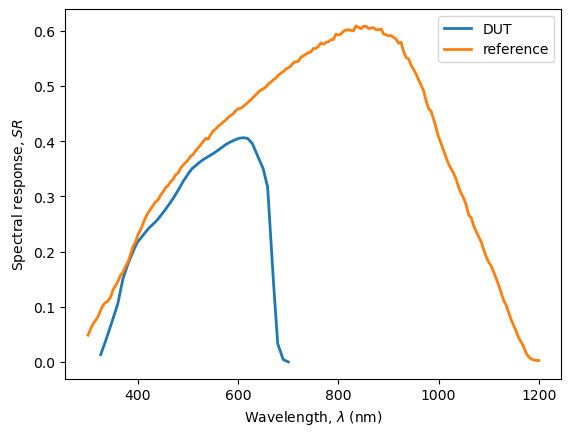

In [17]:
SR_dut=pd.Series(index=QE_dut.index,
            data=[QE_dut.loc[i,'QE']*e*i*0.000000001/(h*c) for i in QE_dut.index])
SR_cal=pd.Series(index=QE_cal.index,
            data=[QE_cal.loc[i,'QE']*e*i*0.000000001/(h*c) for i in QE_cal.index])
plt.plot(SR_dut, 
         linewidth=2,
        label='DUT')
plt.plot(SR_cal, 
         linewidth=2,
        label='reference')
plt.legend()
plt.ylabel('Spectral response, $SR$')
plt.xlabel(r'Wavelength, $\lambda$ (nm)');

For every spectra and solar cell, we interpolate the spectrum at those datapoints included in the SR, and integrate to obtain the short-circuit current density using Eq. 3.5.

$J_{L, spectrum, cell}=\int SR(\lambda) \cdot G(\lambda) \ d\lambda$


In [18]:
spectra=quartz_w['W halogen lamp (W*m-2*nm-1)']
spectra_interpolated=np.interp(SR_dut.index, spectra.index, spectra.values)
J_sim_dut = np.trapz([x*y for x,y in zip(SR_dut, spectra_interpolated)], x=SR_dut.index)*1000/10000 # A-> mA ; m2 -> cm2
spectra_interpolated=np.interp(SR_cal.index, spectra.index, spectra.values)
J_sim_cal = np.trapz([x*y for x,y in zip(SR_cal, spectra_interpolated)], x=SR_cal.index)*1000/10000 # A-> mA ; m2 -> cm2

spectra=reference['AM1.5G']
spectra_interpolated=np.interp(SR_dut.index, spectra.index, spectra.values)
J_ref_dut =np.trapz([x*y for x,y in zip(SR_dut, spectra_interpolated)], x=SR_dut.index)*1000/10000 # A-> mA ; m2 -> cm2

spectra_interpolated=np.interp(SR_cal.index, spectra.index, spectra.values)
J_ref_cal =np.trapz([x*y for x,y in zip(SR_cal, spectra_interpolated)], x=SR_cal.index)*1000/10000 # A-> mA ; m2 -> cm2

We calculate the Spectral Mismatch Factor $M_f$ using Eq. 12.2

$M_f=\frac{J_{L, sim, dut}}{J_{L, ref, dut}}\frac{J_{L, ref, cal}}{J_{L, sim, cal}}$


In [19]:
M_f=J_sim_dut/J_ref_dut*J_ref_cal/J_sim_cal
print('Spectral Mismatch Factor = ' + str(M_f.round(3)))

Spectral Mismatch Factor = 0.45
